In [47]:
%pip install pandas numpy matplotlib scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, math, random, time
from scipy.optimize import minimize

Note: you may need to restart the kernel to use updated packages.


# Calibrating the accelerometer based on gravity vector length

In [48]:
SENSOR_DATA = 'recordings/still_orientations2.csv'
ALGORITHM_DATA = SENSOR_DATA.replace('recordings/', 'analysis/').replace('.csv', '_algo.csv')
ANGLES_DATA = SENSOR_DATA.replace('recordings/', 'analysis/').replace('.csv', '_angles.csv')

### Load sensor data

In [49]:
sensors = pd.read_csv(SENSOR_DATA)
# Convert ESP32 system time to local time so the graphs make more sense.
sensors['t'] = pd.to_datetime((sensors['time'] / 1_000_000_000.0), unit='s')
sensors.set_index(sensors['t'], inplace=True)
sensors.drop(columns=['t'], inplace=True)
sensors

,time,gyro.x,gyro.y,gyro.z,accel.x,accel.y,accel.z
t,,,,,,,
1970-01-01 00:28:52.380426,1732380426000,-0.000133,-0.000133,0.000133,0.004788,0.008380,9.813833
1970-01-01 00:28:52.387220,1732387220000,-0.000133,0.000000,0.000400,0.002394,0.008380,9.816227
1970-01-01 00:28:52.394750,1732394750000,0.000266,0.000400,0.000133,-0.004788,0.013168,9.817424
1970-01-01 00:28:52.403095,1732403095000,0.000266,0.000266,-0.000133,0.003591,0.009577,9.812635
1970-01-01 00:28:52.411514,1732411514000,0.000266,-0.000266,-0.000266,-0.009577,0.002394,9.803059
...,...,...,...,...,...,...,...
1970-01-01 00:30:26.365367,1826365367000,0.000133,-0.001199,-0.000799,-1.154005,-10.277111,0.894234
1970-01-01 00:30:26.373301,1826373301000,0.000266,0.007194,-0.002398,-1.133654,-10.287885,0.882263
1970-01-01 00:30:26.381066,1826381066000,0.003064,0.018119,-0.003997,-1.155202,-10.283096,0.893037


### Preview raw sensor data

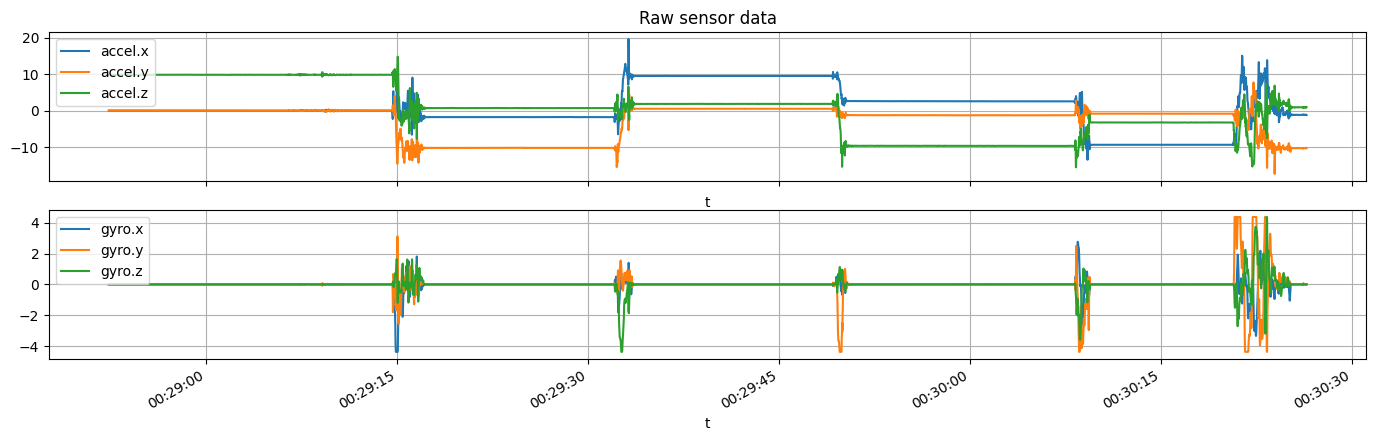

In [50]:
fig, (ax1, ax2) = plt.subplots(2, 1)

sensors['accel.x'].plot(ax=ax1)
sensors['accel.y'].plot(ax=ax1)
sensors['accel.z'].plot(ax=ax1)
ax1.xaxis.set_ticklabels([])
ax1.legend(loc='upper left')
ax1.grid()

sensors['gyro.x'].plot(ax=ax2)
sensors['gyro.y'].plot(ax=ax2)
sensors['gyro.z'].plot(ax=ax2)
ax2.legend(loc='upper left')
ax2.grid()

ax1.set_title('Raw sensor data')
fig.set_figwidth(17)

### Find some regions to take average at rest vectors from

In [79]:
regions = np.array([
    [28*60+55, 29*60+8],
    [29*60+20, 29*60+30],
    [29*60+37, 29*60+45],
    [29*60+55, 30*60+5],
    [30*60+12, 30*60+19],
])

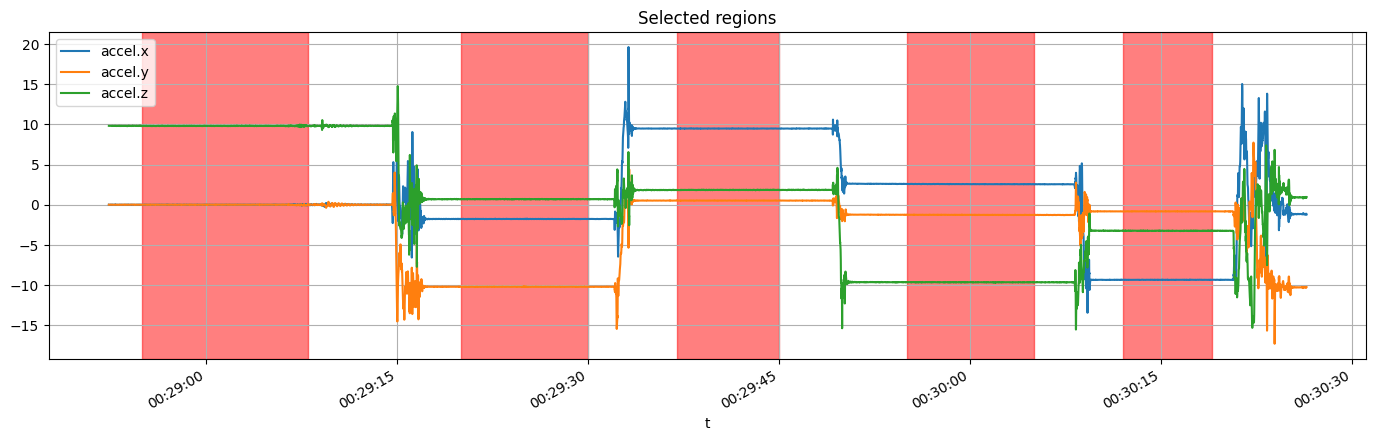

In [80]:
fig, ax1 = plt.subplots(1, 1)

sensors['accel.x'].plot(ax=ax1)
sensors['accel.y'].plot(ax=ax1)
sensors['accel.z'].plot(ax=ax1)
ax1.legend(loc='upper left')
ax1.grid()

to_days = 1 / (24*60*60)
regions_days = regions * to_days
for region in regions_days:
    ax1.axvspan(
        region[0],
        region[1],
        color='red',
        alpha=0.5
    )

ax1.set_title('Selected regions')
fig.set_figwidth(17)

In [89]:
vectors = []

for region in regions:
    start = pd.to_datetime(region[0], unit='s')
    stop = pd.to_datetime(region[1], unit='s')
    mask = (sensors.index > start) & (sensors.index < stop)
    data = sensors.loc[mask].mean(axis=0)
    vectors.append([
        data['accel.x'],
        data['accel.y'],
        data['accel.z'],
    ])

vectors = np.array(vectors)

array([[-6.15862337e-04,  2.84504828e-03,  9.80418594e+00],
       [-1.77118634e+00, -1.02038080e+01,  6.96816117e-01],
       [ 9.47573898e+00,  5.17542180e-01,  1.84090890e+00],
       [ 2.56643404e+00, -1.26017185e+00, -9.63596000e+00],
       [-9.33865811e+00, -8.23214283e-01, -3.24190745e+00]])

In [95]:
# Target magnitude for each vector
target_magnitude = 9.80665

# Objective function to minimize the error in magnitudes
def objective(scalars):
    scaled_vectors = vectors * scalars  # Element-wise scaling
    magnitudes = np.linalg.norm(scaled_vectors, axis=1)
    errors = magnitudes - target_magnitude
    return np.sum(errors**2)

# Initial guess for the scalars (no scaling)
initial_guess = np.ones(3)

# Perform the optimization
result = minimize(objective, initial_guess, method='SLSQP')

# Extract the optimal scalars
optimal_scalars = result.x
print("Optimal scalars (x, y, z):", optimal_scalars)

# Verify the magnitudes of the adjusted vectors
adjusted_vectors = vectors * optimal_scalars
adjusted_magnitudes = np.linalg.norm(adjusted_vectors, axis=1)
print("Adjusted magnitudes:", adjusted_magnitudes)

previous_magnitudes = np.linalg.norm(vectors, axis=1)
print("Previous magnitudes:", previous_magnitudes)

Optimal scalars (x, y, z): [1.0026074  0.942502   0.98757419]
Adjusted magnitudes: [9.68236134 9.80386842 9.68512549 9.92925912 9.92563859]
Previous magnitudes: [ 9.80418637 10.37980495  9.66676909 10.0511861   9.91958573]
